✅ 데이터 로드 완료: CSV, ArUco JSON, Calibration JSON
--- 총 6개의 대표 이미지 랜덤 선택 완료 ---


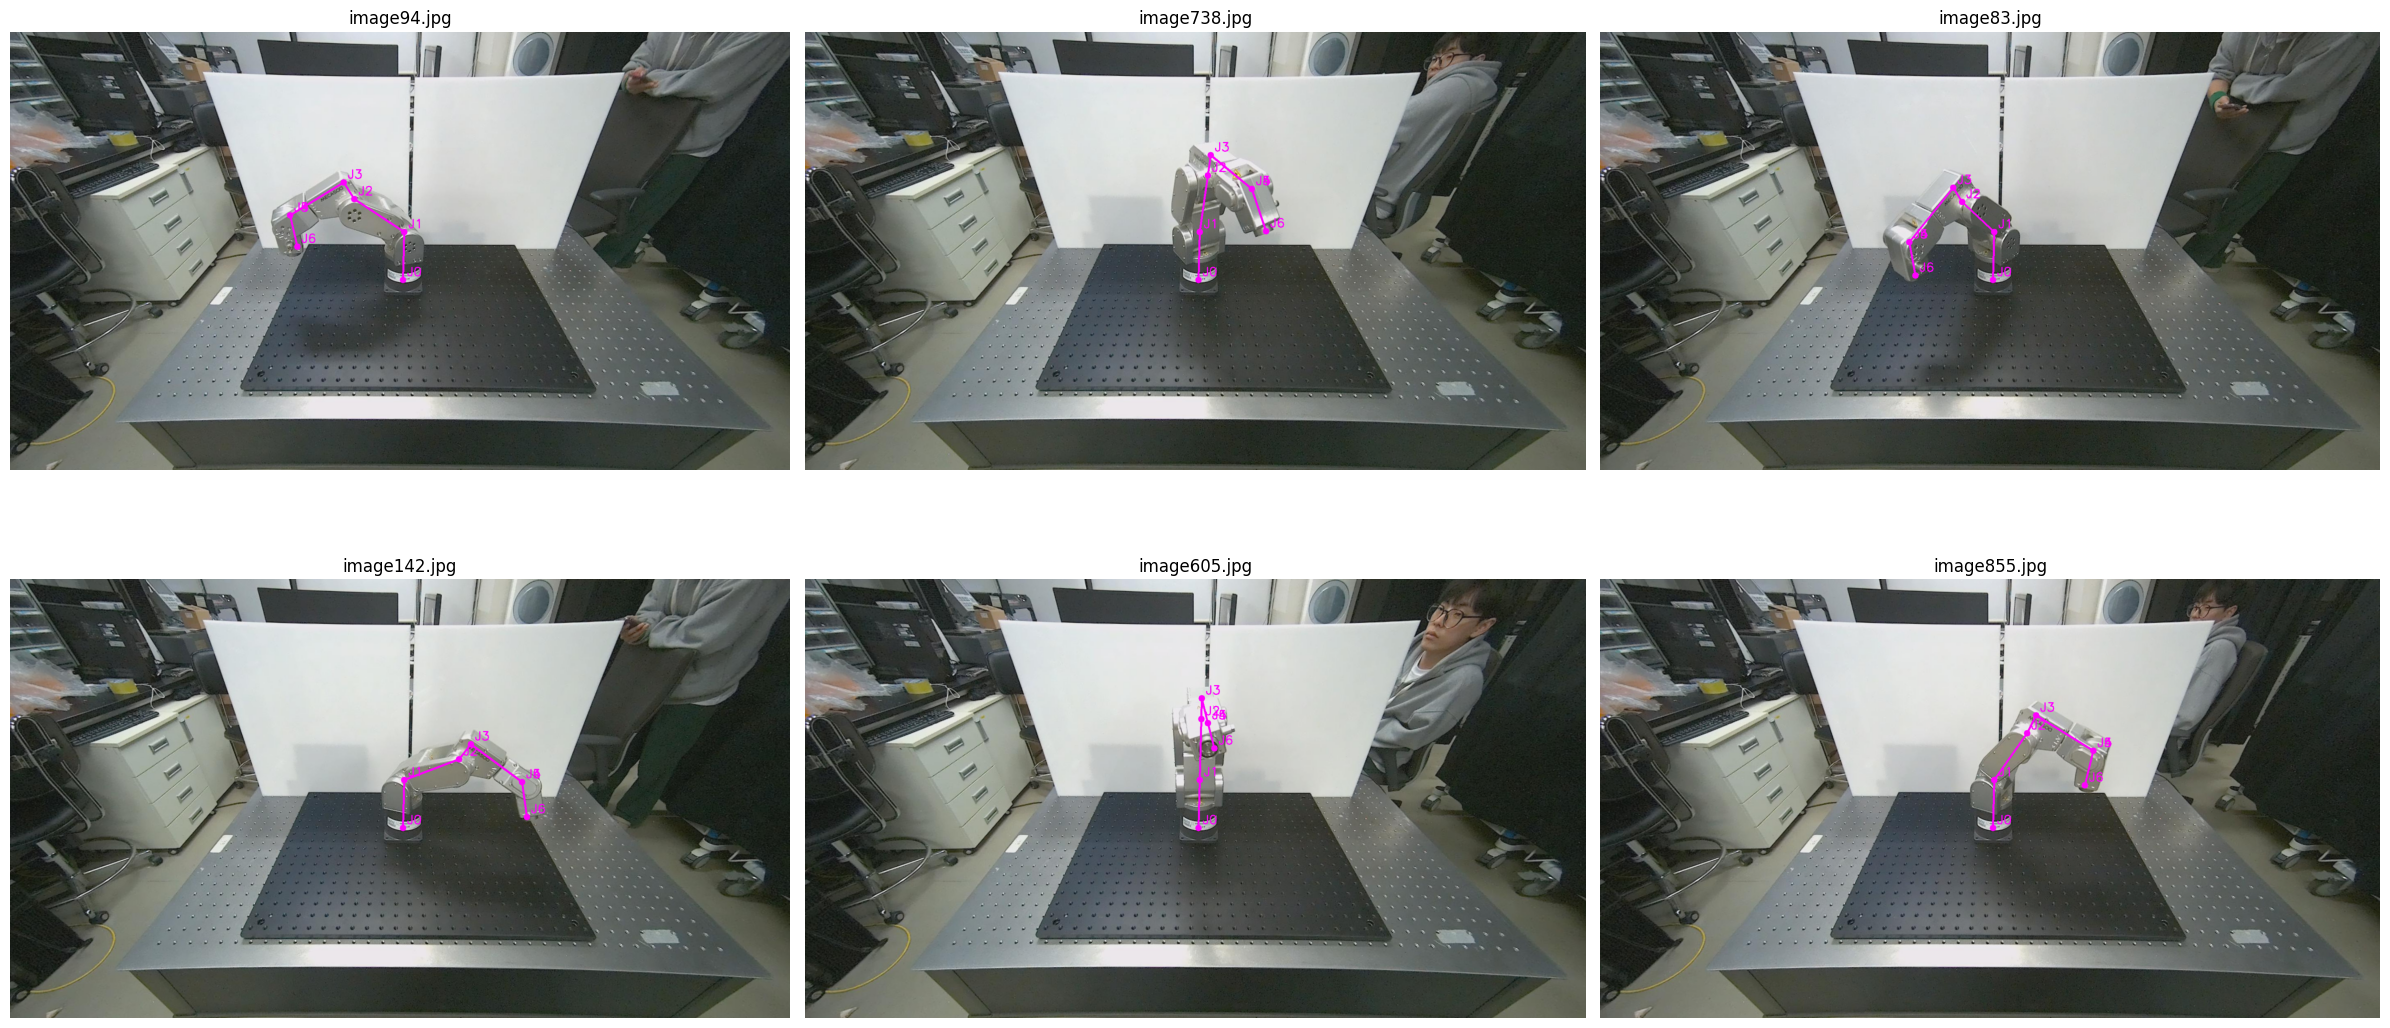

In [20]:
import os
import json
import math
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# --- ⚙️ 1. 설정 변수 ---

# 동기화된 데이터 CSV 파일 경로
SYNC_CSV_PATH = "../dataset/Meca500/Meca500_matched_joint_angle.csv"
# ArUco 마커 포즈 요약 파일 경로
ARUCO_JSON_PATH = "../dataset/Meca500/aruco_pose_summary.json"
# 단일 캘리브레이션 JSON 파일의 전체 경로
CALIB_PATH = "../dataset/Meca500/Meca_calib_cam_from_conf/Meca500_calib.json"


# ===================================================================
# 2. 순기구학 (Forward Kinematics) 계산 (변경 없음)
# ===================================================================
def get_dh_matrix(a, d, alpha, theta):
    """단일 DH 변환 행렬을 계산합니다."""
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad) * np.cos(alpha_rad),  np.sin(theta_rad) * np.sin(alpha_rad), a * np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad) * np.cos(alpha_rad), -np.cos(theta_rad) * np.sin(alpha_rad), a * np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])

def forward_kinematics(joint_angles):
    """주어진 관절 각도에 대한 모든 조인트의 3D 좌표를 계산합니다."""
    dh_params = [
        {'alpha': -90, 'a': 0,     'd': 0.135, 'theta_offset': 0},
        {'alpha': 0,   'a': 0.135, 'd': 0,     'theta_offset': -90},
        {'alpha': -90, 'a': 0.038, 'd': 0,     'theta_offset': 0},
        {'alpha': 90,  'a': 0,     'd': 0.120, 'theta_offset': 0},
        {'alpha': -90, 'a': 0,     'd': 0,     'theta_offset': 0},
        {'alpha': 0,   'a': 0,     'd': 0.070, 'theta_offset': 0}
    ]
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (베이스)
    T_cumulative = np.eye(4)
    base_point = np.array([[0], [0], [0], [1]])
    for i in range(6):
        params = dh_params[i]
        theta = joint_angles[i] + params['theta_offset']
        T_i = get_dh_matrix(params['a'], params['d'], params['alpha'], theta)
        T_cumulative = T_cumulative @ T_i
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
    return np.array(joint_coords_3d, dtype=np.float32)

def project_to_pixel(coords_3d, rvec, tvec, camera_matrix, dist_coeffs):
    """3D 좌표를 2D 이미지 평면에 투영합니다."""
    pixel_coords, _ = cv2.projectPoints(coords_3d, rvec, tvec, camera_matrix, dist_coeffs)
    return pixel_coords.reshape(-1, 2)

# --- 🚀 3. 메인 실행 ---

def main():
    """
    동기화된 CSV 파일을 읽어 랜덤 이미지를 선택하고 로봇 관절 데이터를 시각화합니다.
    """
    # --- 단계 1: 데이터 로드 ---
    try:
        df_sync = pd.read_csv(SYNC_CSV_PATH)
        with open(ARUCO_JSON_PATH, 'r') as f:
            aruco_result = json.load(f)[0] # 단일 카메라 환경이므로 첫 번째 항목을 사용
        with open(CALIB_PATH, 'r') as f:
            calib_data = json.load(f)
    except FileNotFoundError as e:
        print(f"❌ 에러: 필수 파일을 찾을 수 없습니다 - {e}")
        return
    except (IndexError, TypeError):
        print(f"❌ 에러: ArUco JSON 파일({ARUCO_JSON_PATH})이 비어있거나 형식이 잘못되었습니다.")
        return

    print("✅ 데이터 로드 완료: CSV, ArUco JSON, Calibration JSON")

    # --- 단계 2: 시각화할 데이터 랜덤 선택 ---
    num_samples = 6
    if len(df_sync) < num_samples:
        print(f"⚠️ 경고: 데이터 개수({len(df_sync)})가 요청된 샘플 개수({num_samples})보다 적습니다. 모든 데이터를 사용합니다.")
        num_samples = len(df_sync)
    if df_sync.empty:
        print("❌ 시각화할 데이터가 CSV 파일에 없습니다.")
        return
    selected_rows = df_sync.sample(n=num_samples).to_dict('records')
    print(f"--- 총 {len(selected_rows)}개의 대표 이미지 랜덤 선택 완료 ---")

    # --- 단계 3: 선택된 데이터 시각화 ---
    num_cols = 3
    num_rows = (len(selected_rows) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 8, num_rows * 6))
    axes = axes.flatten()

    # 공통으로 사용할 카메라/ArUco 파라미터 준비
    camera_matrix = np.array(calib_data["camera_matrix"], dtype=np.float32)
    dist_coeffs = np.array(calib_data["distortion_coeffs"], dtype=np.float32)
    
    # ArUco Rotation Vector 준비 (Radian 변환 포함)
    rvec_deg = np.array([
        aruco_result.get('rvec_x', 0), # ✅ JSON 키('rvec_x')와 일치
        aruco_result.get('rvec_y', 0), # ✅ JSON 키('rvec_y')와 일치
        aruco_result.get('rvec_z', 0)  # ✅ JSON 키('rvec_z')와 일치
    ], dtype=np.float32)
    rvec = np.deg2rad(rvec_deg)
    
    # ArUco Translation Vector 준비
    tvec = np.array([
        aruco_result.get('tvec_x', 0), # ✅ JSON 키('tvec_x')와 일치
        aruco_result.get('tvec_y', 0), # ✅ JSON 키('tvec_y')와 일치
        aruco_result.get('tvec_z', 0)  # ✅ JSON 키('tvec_z')와 일치
    ], dtype=np.float32).reshape(3, 1)

    for i, row in enumerate(selected_rows):
        ax = axes[i]
        try:
            image_path = row['image_path']
            joint_angles = [row[f'joint_{j}'] for j in range(1, 7)]

            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            undistorted_img = cv2.undistort(image_rgb, camera_matrix, dist_coeffs)

            joint_coords_3d = forward_kinematics(joint_angles)
            pixel_coords = project_to_pixel(joint_coords_3d, rvec, tvec, camera_matrix, np.zeros_like(dist_coeffs))

            font = cv2.FONT_HERSHEY_SIMPLEX
            for idx, (x, y) in enumerate(pixel_coords.astype(int)):
                cv2.circle(undistorted_img, (x, y), 8, (255, 0, 255), -1)
                cv2.putText(undistorted_img, f"J{idx}", (x + 10, y - 10), font, 1.0, (255, 0, 255), 2)
                if idx > 0:
                    prev_x, prev_y = pixel_coords[idx-1].astype(int)
                    cv2.line(undistorted_img, (prev_x, prev_y), (x, y), (255, 0, 255), 3)

            ax.imshow(undistorted_img)
            ax.set_title(os.path.basename(image_path), fontsize=12)

        except Exception as e:
            print(f"❌ 시각화 중 오류 발생: {image_path}, {e}")
            ax.set_title(f"Error", color='red')
        finally:
            ax.axis("off")

    # 남은 subplot 비활성화
    for j in range(len(selected_rows), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()